<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Summary:" data-toc-modified-id="Summary:-1.0.1">Summary:</a></span></li><li><span><a href="#Table-of-Contents:" data-toc-modified-id="Table-of-Contents:-1.0.2">Table of Contents:</a></span></li><li><span><a href="#Motivation:" data-toc-modified-id="Motivation:-1.0.3">Motivation:</a></span><ul class="toc-item"><li><span><a href="#Neurons-as-Activation-Vectors,-Layers-as-Subspaces" data-toc-modified-id="Neurons-as-Activation-Vectors,-Layers-as-Subspaces-1.0.3.1">Neurons as Activation Vectors, Layers as Subspaces</a></span></li></ul></li><li><span><a href="#Canonical-Correlation-Analysis-(CCA)" data-toc-modified-id="Canonical-Correlation-Analysis-(CCA)-1.0.4">Canonical Correlation Analysis (CCA)</a></span></li><li><span><a href="#Our-Work" data-toc-modified-id="Our-Work-1.0.5">Our Work</a></span></li><li><span><a href="#Getting-started-with-CCA-for-Neural-Networks-with-a-Toy-Example" data-toc-modified-id="Getting-started-with-CCA-for-Neural-Networks-with-a-Toy-Example-1.0.6">Getting started with CCA for Neural Networks with a Toy Example</a></span></li><li><span><a href="#How-many-datapoints?" data-toc-modified-id="How-many-datapoints?-1.0.7">How many datapoints?</a></span></li><li><span><a href="#Beyond-Mean-CCA-Correlation-Coefficients:-Cutoffs-and-Thresholds" data-toc-modified-id="Beyond-Mean-CCA-Correlation-Coefficients:-Cutoffs-and-Thresholds-1.0.8">Beyond Mean CCA Correlation Coefficients: Cutoffs and Thresholds</a></span></li><li><span><a href="#Determining-CCA-Similarity-with-an-MNIST-Example" data-toc-modified-id="Determining-CCA-Similarity-with-an-MNIST-Example-1.0.9">Determining CCA Similarity with an MNIST Example</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.0.10">Summary</a></span></li></ul></li></ul></li></ul></div>

# Introduction

### Summary: 
This notebook introduces (SV)CCA as a method to analyze representations in neural networks. We apply this to a network on MNIST, and discuss some important considerations when applying CCA.

### Table of Contents:
1. Motivation
2. Canonical Correlation Analysis (CCA)
3. Our Work
4. Getting started with CCA with a Toy Example
5. How many datapoints?
6. Beyond Mean CCA Correlation Coefficients
7. Determining CCA Similarity with an MNIST Example

In [2]:
import os, sys
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas
import gzip

sys.path.append("..")
import cca_core

In [3]:
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### Motivation:
Given a neural network, we often want to understand the properties of its latent representations: we might be interesting in seeing how different layers converge, comparing multiple networks to determine similarities, or even determining how sensitive different layers are to different classes.

To do this, we first outline a simple formalism for thinking about neural network representations:

![cca_nn](nn_cca.png)

#### Neurons as Activation Vectors, Layers as Subspaces
Suppose we feed inputs $x_1$, $x_2$, $x_3$ into a network. A _neuron_ in the network is going to output three scalar $z_1$, $z_2$, $z_3$ for the three inputs. One simple way to represent what the neuron has learned is by creating an _activation vector_: stacking its output values over the inputs -- in this case the vector $[z_1,z_2,z_3]$. More generally, we might feed in inputs $x_1,...,x_m$, which gives each neuron in the network an activation vector of the form $[z_1,....,z_m]$.

Layers in the network linearly combine their neurons, and so we have the simple formalism -- given a dataset $X=[x_1,...,x_m]$:
1. Neuron representations are (activation) vectors ($\in\mathcal{R}^m$)
2. Layer representations are subspaces spanned by their neurons

### Canonical Correlation Analysis (CCA)
With this formalism, we can apply powerful statistical methods, such as Canonical Correlation Analysis (CCA) to understand properties of deep neural networks. 

At a high level, CCA takes as input the actiations of two sets of neurons $A$, $B$ (typically layers) in response to the same set of inputs and finds linear combinations of the neurons that maximize the correlation between the two layers. Intuitively, it tries to measure whether the two layers are learning similar things, modulo any linear transform.

This means that CCA is **invariant** to (invertible) linear transforms, an _essential_ property when comparing different neural networks to each other.

Section 2 in our paper, [Insights on Representational Similarity](https://arxiv.org/abs/1806.05759) presents a simple mathematical overview of CCA. For more details, here are two nice surveys of CCA and related methods:
1. [A Tutorial on Canonical Correlation Methods](https://arxiv.org/pdf/1711.02391.pdf)
2. [A Unified Approach to PCA, PLS, MLR and CCA](http://www.diva-portal.org/smash/get/diva2:288565/FULLTEXT01.pdf)

For this tutorial, the main thing to note is that given two sets of neurons $A$, $B$, with $n_a$, $n_b$ neurons respectively, CCA will output $min(n_a, n_b)$ correlation coefficients in [0, 1] that tell us how similar the linear combinations are. This will be returned as `results["cca_coef1"]` in the code below.


### Our Work

In our papers:
* [SVCCA: Singular Vector Canonical Correlation Analysis for Deep Learning Dynamics and Interpretability](https://arxiv.org/abs/1706.05806)
* [Insights on Representational Similarity in Neural Networks with Canonical Correlation.](https://arxiv.org/abs/1806.05759)

we use variants of CCA to analyze properties of different kinds of neural networks (fully connected/convolutional/RNN) and discover some interesting conclusions:
1. Bottom up learning dynamics: lower layers in neural networks converge first before higher layers. We can thus consecutively freeze layers through training to save computation and prevent overfitting
2. CCA can be used to compare different neural networks successfully, uncovering latent similarity and even helping perform compression.
3. Comparing generalizing networks (networks trained on the true task) and memorizing networks (networks trained on a random permutation of labels) shows that good generalization often results in more similiarity of the latent representations of neural networks.
4. We can also see how sensitive latent layers are to different classes. On ImageNet, we find that there are easier (e.g. fire trucks) and harder classes (specific dog breeds) for the network

Check out the papers for details and more results!

### Getting started with CCA for Neural Networks with a Toy Example
Now that we've discussed the motivation and the kinds of analysis one can do with CCA, let's work through some examples with the code!

Let's first start with a toy example, where we will generate fake neuron activations as iid Gaussian samples. 

In [4]:
# Toy Example of CCA in action

# assume X_fake has 100 neurons and we have their activations on 1000 datapoints
A_fake = np.random.randn(100, 2000)
# Y_fake has 50 neurons with activations on the same 1000 datapoints
# Note X and Y do *not* have to have the same number of neurons
B_fake = np.random.randn(50, 2000)

# computing CCA simliarty between X_fake, Y_fake
# We expect similarity should be very low, because the fake activations are not correlated
results = cca_core.get_cca_similarity(A_fake, B_fake, verbose=True)


adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


In [6]:
print("Returned Information:")
print(results.keys())

Returned Information:
dict_keys(['coef_x', 'invsqrt_xx', 'full_coef_x', 'full_invsqrt_xx', 'coef_y', 'invsqrt_yy', 'full_coef_y', 'full_invsqrt_yy', 'neuron_means1', 'neuron_means2', 'cca_coef1', 'cca_coef2', 'x_idxs', 'y_idxs', 'mean', 'sum'])


The returned terms include *cca_coef1* and *cca_coef2*. These are the CCA correlation coeffients, which tell us how similar the representations of A, B are. 

There's redundency here -- the correlation coefficients measure how correlated the linear combinations for A, B are, and so *cca_coef1* = *cca_coef2*.

Let's take a closer look:

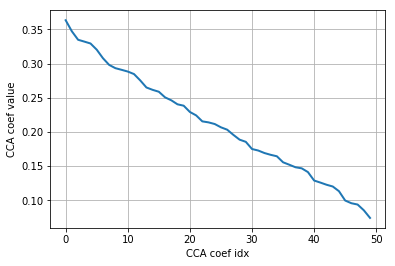

In [7]:
# correlation coefficients
_plot_helper(results["cca_coef1"], "CCA coef idx", "CCA coef value")

We see there are 50 = min(A_fake neurons, B_fake neurons) CCA correlation coefficients, in decreasing order (from most correlated to least correlated.)

We'll return to this in more detail soon, but for now, if we want a single number to summarize how similar the representations of A_fake, B_fake are, we can e.g. take the mean of these coefficients:

In [9]:
print("Single number for summarizing similarity")
print('{:.4f}'.format(np.mean(results["cca_coef1"])))

Single number for summarizing similarity
0.2111


This is a simple baseline we can compare other results to. As an example, let's see what the similarity looks like when we compare A to a scaled invertible transform of A. CCA is invariant to these, so we expect to see perfect CCA correlation.

In [10]:
At_fake = np.dot(np.random.randn(100, 100), A_fake)

results_t = cca_core.get_cca_similarity(A_fake, At_fake)

adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


Single number for summarizing similarity
1.0000


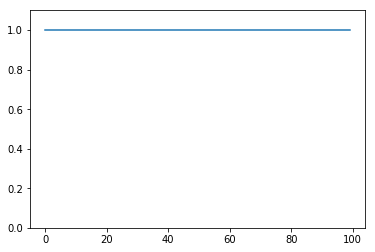

In [12]:
plt.plot(results_t["cca_coef1"])
plt.ylim((0,1.1))
print("Single number for summarizing similarity")
print('{:.4f}'.format(np.mean(results_t["cca_coef1"])))

This is indeed what we observe -- a good sanity check!

### How many datapoints?
In the toy example above, we had a 2000 dimensional (fake) activation vector for each neuron in A, B. With a neural network, this would mean we had 2000 datapoints that we used to get each neuron's activation vector. 

Is 2000 always the appropriate number of datapoints to use?

In general, the we want there to be enough datapoints so that CCA doesn't pick up spurious correlations. For example, suppose we have only as many datapoints as neurons. Then CCA will likely find linear combinations of the neurons in A, B such that there is high correlation on this small set of datapoints, but this won't generalize to larger amounts of data.

**The TL;DR** Ideally we have an order of magnitude more datapoints than neurons that we're applying CCA over e.g. 5x --10x the amount of data.

Let's look at this in more detail: we'll compute CCA similarity in our toy case from before, but this time vary the number of datapoints.

With enough datapoints, CCA computations should tell us that there is no meaningful similarity between A_fake, B_fake.

Text(0, 0.5, 'Mean CCA Correlation Coefficient')

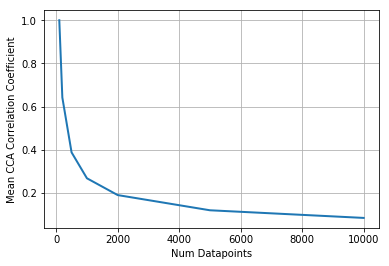

In [13]:
sresults = []
num_datapoints = [101, 200, 500, 1000, 2000, 5000, 10000]
for nd in num_datapoints:
    A_fake = np.random.randn(100, nd)
    B_fake = np.random.randn(100, nd)
    
    results = cca_core.get_cca_similarity(A_fake, B_fake, verbose=False)
    sresults.append(np.mean(results["cca_coef1"]))
    
plt.plot(num_datapoints, sresults, lw=2.0)
plt.grid()
plt.xlabel("Num Datapoints")
plt.ylabel("Mean CCA Correlation Coefficient")
    

We see that CCA similarity goes down as the number of datapoints increases. This drop is particularly steep in the 100 to 500 datapoints range, though there's also a 0.1 drop in the 2000 to 10000 datapoints range.

It's not always feasible to use enormous numbers of datapoints (for example, if there are memory constraints.) But two useful rules of thumb are:
1. Pick the number of datapoints to be at least a few times larger than the number of neurons.
2. Compute a baseline with your number of datapoints, where CCA correlation should be low, and analyze results relative to this.

### Beyond Mean CCA Correlation Coefficients: Cutoffs and Thresholds

So far we've been using the mean CCA Correlation Coefficient as a single number summarizing the similarity between our two sets of activations A, B. 

But in neural network layers, the full dimensionality of the layer (the number of neurons it has) might not be used for the task at hand. So computing a mean over all CCA correlation coefficients likely gives a pessimistic value for how similar two networks are.

In our work, we proposed two variants of CCA to help address this, [SVCCA](https://arxiv.org/abs/1706.05806) (preprocess neuron activation vectors with an SVD to remove low variance directions) and [PWCCA](https://arxiv.org/abs/1806.05759) (a projection weighted mean of CCA correlation coefficients.) 

Both of these methods are heuristics, and were designed with the idea that small variance directions in neural networks might not correspond to meaningful signal. However, this might not be applicable in some settings, e.g. with saturating non-linearities.

This problem with determining a good cutoff for CCA coefficients is a long standing one. On page 11 of our [Insights](https://arxiv.org/abs/1806.05759) paper, we overview a hypothesis test, Bartlett's test, that has been used to determine CCA cutoffs.

Another method is to plot the log of the CCA correlation coefficients, and if there is a change in convexity, use that as a threshold.

Yet another simple method is to compute the mean CCA correlation coefficient over the first n CCA correlation coefficients, where the first n coefficients correspond to some threshold% of the mass of the CCA correlation coefficients: i.e. 

`np.sum(results["cca_coef1"][:n])/np.sum(results["cca_coef1"]) = threshold`

The `get_cca_similarity()` function has an optional threshold argument that does this when computing the `results["mean"]` value. By default, the threshold is set to 0.98.

Below, we work through several of these methods on an MNIST Example.

### Determining CCA Similarity with an MNIST Example

Let's look at applying CCA to a fully connected network trained on MNIST. The network architecture has three hidden layers of width 500, so looks like:

784 (Input) --- 500 --- 500 --- 500 -- 10 (Output)

In the model_activations/MNIST/ folder, we have saved activations from two networks with this architecture on two training runs on MNIST. For this tutorial, we've taken the activations over the 10000 test set examples.

In [14]:
# Load up second hidden layer of MNIST networks and compare
with open("./model_activations/MNIST/model_0_lay02.p", "rb") as f:
    acts1 = pickle.load(f)
with open("./model_activations/MNIST/model_1_lay02.p", "rb") as f:
    acts2 = pickle.load(f)
    
print("activation shapes", acts1.shape, acts2.shape)

results = cca_core.get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)
    

activation shapes (500, 10000) (500, 10000)


Note that we've added a small value to `epsilon` here -- this is to ensure that the numpy svd routine converges correctly by removing neurons with very small activations and regularizing one of the computations with an identity matrix.

Mean CCA similarity 0.4067667082085896


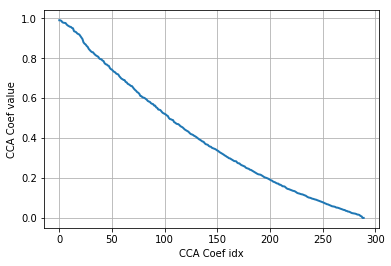

In [15]:
_plot_helper(results["cca_coef1"], "CCA Coef idx", "CCA Coef value")
print("Mean CCA similarity", np.mean(results["cca_coef1"]))

Just taking a mean similarity and looking at the plot seems to suggest that these two representations aren't that similar. But we have to be more careful here. Let's try doing an SVD over one of the set of activations to see how many large variance directions there are:

Fraction of variance explained by 20 singular vectors 0.5076149


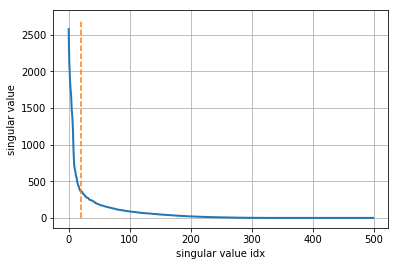

In [16]:
_, s, v = np.linalg.svd(acts1 - np.mean(acts1, axis=1, keepdims=True), full_matrices=False)
_plot_helper(s, "singular value idx", "singular value")
plt.plot([20]*100, np.linspace(0, 2700, 100), linestyle="--")
print("Fraction of variance explained by 20 singular vectors", np.sum(s[:20])/np.sum(s))

Plotting the singular values shows that 20 singular values, i.e. 20 dimensions, are enough to explain more than 50% of the variance of the activations. So we probably don't want to take an average over all the neurons(=500) to measure CCA similarity. Let's see how different methods work here.

First, we're going to make a baseline to compare with. In this example we'll use the simple baseline of comparing iid Gaussian variables with each other. Other baselines could be the similarity of neural networks at random initialization.

In [17]:
# creating a random baseline
b1 = np.random.randn(*acts1.shape)
b2 = np.random.randn(*acts2.shape)

Baseline Mean CCA similarity 0.1905200249986317
MNIST Mean CCA similarity 0.4067667082085896


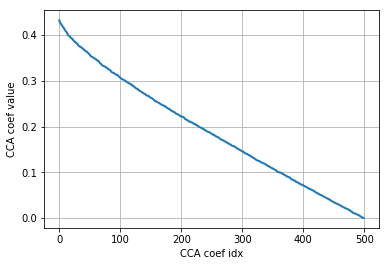

In [19]:
baseline = cca_core.get_cca_similarity(b1, b2, epsilon=1e-10, verbose=False)
_plot_helper(baseline["cca_coef1"], "CCA coef idx", "CCA coef value")
print("Baseline Mean CCA similarity", np.mean(baseline["cca_coef1"]))
print("MNIST Mean CCA similarity", np.mean(results["cca_coef1"]))

There's a clear difference between the baseline mean CCA similarity and the MNIST mean CCA similarity, but let's see if we can separate things further.

##### 1. Averaging Top CCA Values

In [16]:
# comparing different results
print("Results when averaging top CCA values")
print("Baseline", np.mean(baseline["cca_coef1"][:20]), "and MNIST", np.mean(results["cca_coef1"][:20]))

Results when averaging top CCA values
Baseline 0.411481949518 and MNIST 0.957506517411


##### 2. Using SVCCA

Results using SVCCA keeping 20 dims
Baseline 0.03495124739462908 and MNIST 0.7362758928888706


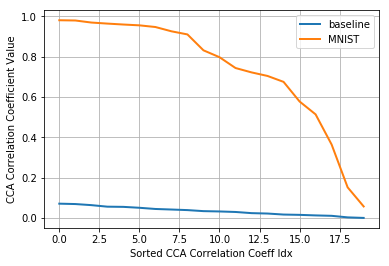

In [20]:
print("Results using SVCCA keeping 20 dims")

# Mean subtract activations
cacts1 = acts1 - np.mean(acts1, axis=0, keepdims=True)
cacts2 = acts2 - np.mean(acts2, axis=0, keepdims=True)

# Perform SVD
U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

svacts1 = np.dot(s1[:20]*np.eye(20), V1[:20])
# can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
svacts2 = np.dot(s2[:20]*np.eye(20), V2[:20])
# can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)

# Mean subtract baseline activations
cb1 = b1 - np.mean(b1, axis=0, keepdims=True)
cb2 = b2 - np.mean(b2, axis=0, keepdims=True)

# Perform SVD
Ub1, sb1, Vb1 = np.linalg.svd(cb1, full_matrices=False)
Ub2, sb2, Vb2 = np.linalg.svd(cb2, full_matrices=False)

svb1 = np.dot(sb1[:20]*np.eye(20), Vb1[:20])
svb2 = np.dot(sb2[:20]*np.eye(20), Vb2[:20])

svcca_baseline = cca_core.get_cca_similarity(svb1, svb2, epsilon=1e-10, verbose=False)
print("Baseline", np.mean(svcca_baseline["cca_coef1"]), "and MNIST", np.mean(svcca_results["cca_coef1"]))

plt.plot(svcca_baseline["cca_coef1"], lw=2.0, label="baseline")
plt.plot(svcca_results["cca_coef1"], lw=2.0, label="MNIST")
plt.xlabel("Sorted CCA Correlation Coeff Idx")
plt.ylabel("CCA Correlation Coefficient Value")
plt.legend(loc="best")
plt.grid()


##### 3. Using PWCCA

In [21]:
import pwcca
pwcca_mean, w, _ = pwcca.compute_pwcca(acts1, acts2, epsilon=1e-10)
pwcca_baseline, wb, _ = pwcca.compute_pwcca(b1, b2, epsilon=1e-10)
print("Results using PWCCA")
print("Baseline", pwcca_baseline, "and MNIST", pwcca_mean)

Results using PWCCA
Baseline 0.19217130975687105 and MNIST 0.7364445444651748


We see that all the methods (averaging top values, SVCCA and PWCCA) greater accentuate the differences in CCA similarity between the baseline and MNIST.

SVCCA highlights the greatest difference in this setting, but the downside is that a threshold for the number of dimensions used has to be chosen, while PWCCA doesn't require this.

Note that these methods are mostly heuristics, and there are many further open questions to explore here!

### Summary
In this tutorial, we've seen:
1. A simple formalism for representations in deep neural networks (neurons as activation vectors.)
2. How to use the `cca_core` functions to apply CCA to deep neural networks
3. Determining the number of datapoints for CCA
4. Looking at different ways to perform cutoffs and get a single similarity score.

In the following tutorials, we'll look at CCA for convolutional layers, and methods related to CCA for model compression and ablation studies.